# Lab 05: Building a Pitch Classifier

---
author: Ethan Wee
date: October 19, 2023
embed-resources: true
---

## Introduction and Data

**Goal:** The goal of this lab is to create a **pitch classifier** that can be used as a part of an automatic system. It should predict the "pitch type" based on the pitch's velocity and spin rate.

What is a pitch type you might ask? Well, it's complicated. Let's allow someone else to explain:

- [YouTube: How to identify baseball pitches](https://www.youtube.com/watch?v=1FTFWzcgjHE)

As we'll see in a moment, while the pitch type is technically defined by what the pitcher claims they threw, we can probably infer the pitch type based on only speed and spin.

Now that you're a pitch type expert, here's a game to see how well you can identify pitches from video:

- [Baseball Savant: Guess the Pitch Type](https://baseballsavant.mlb.com/games/pitch-type-guess)

That game was difficult wasn't it? Don't feel bad! Identifying pitches with your eyes is difficult. It is even more difficult when you realize the cameras are playing tricks on you:

- [Youtube: Camera angles in MLB and how it affects us, A Deep-Dive](https://www.youtube.com/watch?v=T44FnMSgTy8)

But wait! Then how do television broadcasts of baseball games instantly display the pitch type? You guessed it... machine learning! For a deep dive on how they do this, see here:

- [MLB Technology Blog: MLB Pitch Classification](https://technology.mlblogs.com/mlb-pitch-classification-64a1e32ee079)

The long story short is:

- Have advanced tracking technology that can instantly record speed and spin for each pitch.
- Have a trained classifier for pitch type based on speed and spin.
- In real time, make predictions of pitch type as soon as the speed and spin are recorded.
- Display the result in the stadium and on the broadcast!

To do this, you'll need to import the following:

In [23]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import warnings

# machine learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# baseball data

from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup


You are free to import additional packages and modules as you see fit, but this lab can be completed with only the above.

We will use the [**`pybaseball`**](https://pypi.org/project/pybaseball/) package to obtain Statcast data. Statcast is a term used for data produced by MLB Advanced Media and published on MLB's [Baseball Savant](https://baseballsavant.mlb.com/). One method to obtain data from this service is to use the so-called [Statcast Search](https://baseballsavant.mlb.com/statcast_search). However, the `pybaseball` package provides the ability to directly obtain data from within Python.

Documentation for this data can be found here: [Statcast Search CSV Documentation](https://baseballsavant.mlb.com/csv-docs)

The following code is a bit of necessary setup before we move to obtaining data for two particular pitchers.

In [3]:
# deal with pandas versus seaborn issues
warnings.simplefilter(action="ignore", category=FutureWarning)

# define the dates of the regular season
# https://en.wikipedia.org/wiki/2023_Major_League_Baseball_season
start_date_2023 = "2023-03-30"
end_date_2023 = "2023-10-01"

# define required columns for (basic) pitch classifier
pitch_cols = ["pitch_name", "release_speed", "release_spin_rate"]


### Justin Verlander

[Justin Verlander](https://www.baseball-reference.com/players/v/verlaju01.shtml) is a pitcher for the [2023 Houston Astros](https://www.baseball-reference.com/teams/HOU/2023.shtml).

- [Baseball Savant: Justin Verlander](https://baseballsavant.mlb.com/savant-player/justin-verlander-434378?stats=statcast-r-pitching-mlb)

All **V**erlander data will be prefaced with a `v`, such as `vX_train`.

In [4]:
# access and process Verlander train and test data
# playerid_lookup("Verlander", "Justin")
verlander_key_mlbam = 434378
verlander_pitches = statcast_pitcher(start_date_2023, end_date_2023, verlander_key_mlbam)
verlander_pitches = verlander_pitches[pitch_cols]
verlander_pitches = verlander_pitches.dropna()
vX = verlander_pitches[["release_speed", "release_spin_rate"]]
vy = verlander_pitches["pitch_name"].astype("category")
vX_train, vX_test, vy_train, vy_test = train_test_split(vX, vy, test_size=0.2, random_state=42)


Gathering Player Data


In [5]:
# gather verlander train data into a df
verladner_train_df = pd.concat([pd.DataFrame(vX_train), pd.DataFrame(vy_train)], axis=1)
verladner_train_df


,release_speed,release_spin_rate,pitch_name
25,84.9,1740.0,Changeup
1733,94.8,2483.0,4-Seam Fastball
1721,94.3,2490.0,4-Seam Fastball
1693,84.5,2088.0,Changeup
1583,86.6,2715.0,Slider
...,...,...,...
1639,94.4,2451.0,4-Seam Fastball
1095,94.6,2449.0,4-Seam Fastball
1130,93.6,2447.0,4-Seam Fastball
1294,87.8,2573.0,Slider


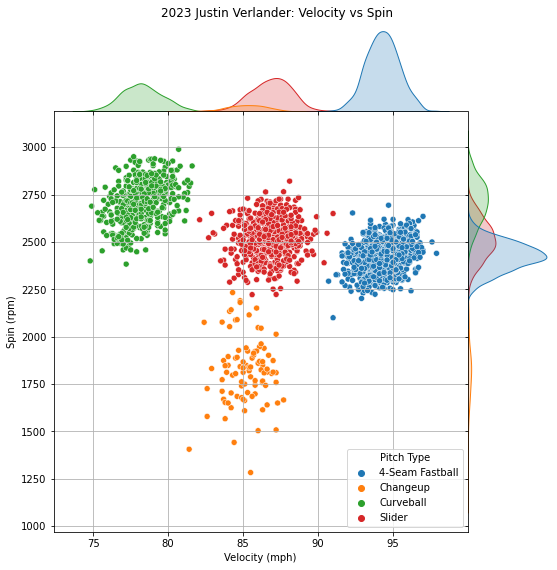

In [6]:
# plot verlander data
verlander_plot = sns.jointplot(data=verladner_train_df, x="release_speed", y="release_spin_rate", hue="pitch_name", space=0)
verlander_plot.set_axis_labels("Velocity (mph)", "Spin (rpm)")
verlander_plot.fig.suptitle("2023 Justin Verlander: Velocity vs Spin", y=1.01)
verlander_plot.ax_joint.legend(title="Pitch Type", loc="lower right")
verlander_plot.ax_joint.grid(True)
verlander_plot.fig.set_size_inches(8, 8)


### Zack Wheeler

[Zack Wheeler](https://www.baseball-reference.com/players/w/wheelza01.shtml) is a pitcher for the [2023 Philadelphia Phillies](https://www.baseball-reference.com/teams/PHI/2023.shtml).

- [Baseball Savant: Zack Wheeler](https://baseballsavant.mlb.com/savant-player/zack-wheeler-554430?stats=statcast-r-pitching-mlb)

All **W**heeler data will be prefaced with a `w`, such as `wX_train`.

In [7]:
# access and process Wheeler train and test data
# playerid_lookup("Wheeler", "Zack")
# NOTE: changeups are removed because very few were thrown, and are possibly errors or wild pitches misclassified
wheeler_key_mlbam = 554430
wheeler_pitches = statcast_pitcher(start_date_2023, end_date_2023, wheeler_key_mlbam)
wheeler_pitches = wheeler_pitches[pitch_cols]
wheeler_pitches = wheeler_pitches.dropna()
wheeler_pitches = wheeler_pitches[wheeler_pitches["pitch_name"] != "Changeup"]
wX = wheeler_pitches[["release_speed", "release_spin_rate"]]
wy = wheeler_pitches["pitch_name"].astype("category")
wX_train, wX_test, wy_train, wy_test = train_test_split(wX, wy, test_size=0.2, random_state=42)


Gathering Player Data


In [8]:
# gather wheeler train data into a df
wheeler_train_df = pd.concat([pd.DataFrame(wX_train), pd.DataFrame(wy_train)], axis=1)
wheeler_train_df


,release_speed,release_spin_rate,pitch_name
548,96.6,2486.0,4-Seam Fastball
1374,95.1,2543.0,4-Seam Fastball
2255,97.3,2608.0,4-Seam Fastball
2377,93.8,2411.0,4-Seam Fastball
1096,95.8,2365.0,Sinker
...,...,...,...
3114,94.1,2539.0,4-Seam Fastball
1102,84.7,2681.0,Sweeper
1137,95.7,2548.0,4-Seam Fastball
1302,95.6,2618.0,4-Seam Fastball


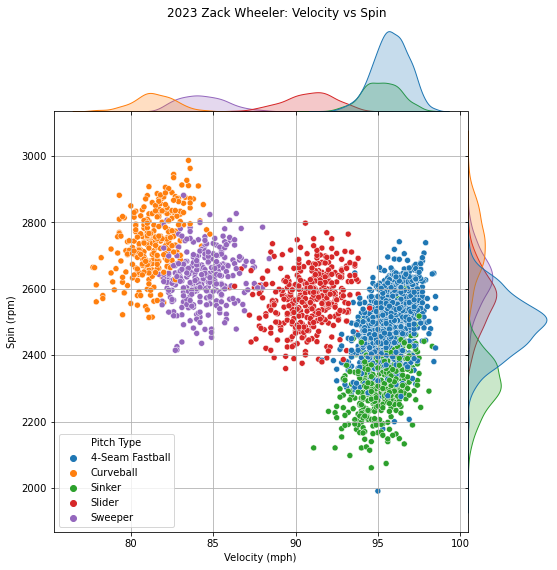

In [9]:
# plot wheeler data
wheeler_plot = sns.jointplot(data=wheeler_train_df, x="release_speed", y="release_spin_rate", hue="pitch_name", space=0)
wheeler_plot.set_axis_labels("Velocity (mph)", "Spin (rpm)")
wheeler_plot.fig.suptitle("2023 Zack Wheeler: Velocity vs Spin", y=1.01)
wheeler_plot.ax_joint.legend(title="Pitch Type", loc="lower left")
wheeler_plot.ax_joint.grid(True)
wheeler_plot.fig.set_size_inches(8, 8)


## Summary Statistics (Graded Work)

Before modeling, you need to **look at the data**!. To do so, you should calculate several **summary statistics** for the training data for the two pitchers. To assist, we have provide each pitcher's training data as a `pandas` data frame that contains both the `X` and `y` information.

- `verlander_train_df`
- `wheeler_train_df`

In [10]:
print(len(verladner_train_df[verladner_train_df["pitch_name"]=="4-Seam Fastball"]))
print(1027/len(verladner_train_df))

print(len(verladner_train_df[verladner_train_df["pitch_name"]=="Changeup"]))
print(95/len(verladner_train_df))

print(len(verladner_train_df[verladner_train_df["pitch_name"]=="Slider"]))
print(520/len(verladner_train_df))

print(len(verladner_train_df[verladner_train_df["pitch_name"]=="Curveball"]))
print(425/len(verladner_train_df))

1027
0.4968553459119497
95
0.045960328979196906
520
0.25157232704402516
425
0.20561199806482824


In [11]:
print(verladner_train_df[verladner_train_df["pitch_name"]=="4-Seam Fastball"].release_speed.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="4-Seam Fastball"].release_speed.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Changeup"].release_speed.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Changeup"].release_speed.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Curveball"].release_speed.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Curveball"].release_speed.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Slider"].release_speed.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Slider"].release_speed.std())

94.29785783836425
1.0904848463152885
85.2084210526316
1.2271453778079746
78.25058823529415
1.3187708264841902
86.8465384615384
1.3427129879742363


In [12]:
print(verladner_train_df[verladner_train_df["pitch_name"]=="4-Seam Fastball"].release_spin_rate.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="4-Seam Fastball"].release_spin_rate.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Changeup"].release_spin_rate.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Changeup"].release_spin_rate.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Curveball"].release_spin_rate.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Curveball"].release_spin_rate.std())

print(verladner_train_df[verladner_train_df["pitch_name"]=="Slider"].release_spin_rate.mean())
print(verladner_train_df[verladner_train_df["pitch_name"]=="Slider"].release_spin_rate.std())

2426.4099318403114
77.11220918729947
1822.4421052631578
175.6207056438388
2711.974117647059
111.75331571728368
2513.7903846153845
103.28828794978382


In [13]:
verladner_train_df


,release_speed,release_spin_rate,pitch_name
25,84.9,1740.0,Changeup
1733,94.8,2483.0,4-Seam Fastball
1721,94.3,2490.0,4-Seam Fastball
1693,84.5,2088.0,Changeup
1583,86.6,2715.0,Slider
...,...,...,...
1639,94.4,2451.0,4-Seam Fastball
1095,94.6,2449.0,4-Seam Fastball
1130,93.6,2447.0,4-Seam Fastball
1294,87.8,2573.0,Slider


In [14]:
print(len(wheeler_train_df[wheeler_train_df["pitch_name"]=="4-Seam Fastball"]))
print(1100/len(wheeler_train_df))

print(len(wheeler_train_df[wheeler_train_df["pitch_name"]=="Curveball"]))
print(280/len(wheeler_train_df))

print(len(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sinker"]))
print(452/len(wheeler_train_df))

print(len(wheeler_train_df[wheeler_train_df["pitch_name"]=="Slider"]))
print(371/len(wheeler_train_df))

print(len(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sweeper"]))
print(303/len(wheeler_train_df))

1100
0.4389465283320032
280
0.11173184357541899
452
0.18036711891460494
371
0.14804469273743018
303
0.1209098164405427


In [15]:
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="4-Seam Fastball"].release_speed.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="4-Seam Fastball"].release_speed.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Curveball"].release_speed.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Curveball"].release_speed.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sinker"].release_speed.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sinker"].release_speed.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Slider"].release_speed.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Slider"].release_speed.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sweeper"].release_speed.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sweeper"].release_speed.std())

95.76981818181811
1.0741896933942017
81.36964285714284
1.276155691400667
95.19933628318589
1.1355081311603032
90.82991913746629
1.528431361192255
84.34488448844888
1.38541309372161


In [16]:
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="4-Seam Fastball"].release_spin_rate.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="4-Seam Fastball"].release_spin_rate.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Curveball"].release_spin_rate.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Curveball"].release_spin_rate.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sinker"].release_spin_rate.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sinker"].release_spin_rate.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Slider"].release_spin_rate.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Slider"].release_spin_rate.std())

print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sweeper"].release_spin_rate.mean())
print(wheeler_train_df[wheeler_train_df["pitch_name"]=="Sweeper"].release_spin_rate.std())

2494.6236363636363
88.12730774708976
2739.8142857142857
93.1107242139469
2315.9867256637167
82.48931826775721
2570.89218328841
81.33267830555873
2634.3927392739274
78.67748451510032


In [17]:
wheeler_train_df

,release_speed,release_spin_rate,pitch_name
548,96.6,2486.0,4-Seam Fastball
1374,95.1,2543.0,4-Seam Fastball
2255,97.3,2608.0,4-Seam Fastball
2377,93.8,2411.0,4-Seam Fastball
1096,95.8,2365.0,Sinker
...,...,...,...
3114,94.1,2539.0,4-Seam Fastball
1102,84.7,2681.0,Sweeper
1137,95.7,2548.0,4-Seam Fastball
1302,95.6,2618.0,4-Seam Fastball


What summary statistics should be calculated? See the relevant assignment on PrairieLearn!

- [Lab 05: Building a Pitch Classifier ](https://us.prairielearn.com/pl/course_instance/140731/assessment_instance/6270266)

## Model Training (Graded Work)

For this lab, you may train models however you'd like! You should train a model for each of the two pitchers, Verlander and Wheeler.

The only rules are:

- Models must start from the given training data, unmodified.
- You must use cross-validation and tune across at least one tuning parameter.

You will submit your chosen model to an autograder to checking. It will calculate your models performance on the test data. Notice that, because you will have unlimited attempts, this somewhat encourages checking against test data multiple times. But you know this is bad in practice. Also, if you use cross-validation to find a good model before submitting, hopefully you'll only need to submit once!

In [18]:
# use this cell to train models for verlander
#verladner_train_df
verlander_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("randomforest",RandomForestClassifier(criterion = "gini"))

])
verlander_parameter_grid = {
    "randomforest__max_depth":[4,5,8],
    "randomforest__min_samples_split":[3,6,11]
}
verlander_randomforestgrid = (GridSearchCV(verlander_pipe,verlander_parameter_grid,cv = 5))
verlander_randomforestgrid.fit(vX_train,vy_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             param_grid={'randomforest__max_depth': [4, 5, 8],
                         'randomforest__min_samples_split': [3, 6, 11]})

In [25]:
# use this cell to train models for wheeler
#wheeler_train_df
wheeler_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("randomforest",RandomForestClassifier(criterion = "gini"))

])
wheeler_parameter_grid = {
    "randomforest__max_depth":[3,5,7],
    "randomforest__min_samples_split":[2,5,10]
}
wheeler_randomforestgrid = (GridSearchCV(wheeler_pipe,wheeler_parameter_grid,cv = 5))
wheeler_randomforestgrid.fit(wX_train,wy_train)

wheeler_randomforestgrid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             param_grid={'randomforest__max_depth': [3, 5, 7],
                         'randomforest__min_samples_split': [2, 5, 10]})

To submit your models to the autograder, you will need to [serialize](https://scikit-learn.org/stable/model_persistence.html) them. In the following cell, replace `_____` with the model you have found for Verlander and Wheeler, respectively.

In [26]:
dump(verlander_randomforestgrid, "v_model.joblib")
dump(wheeler_randomforestgrid, "w_model.joblib")


['w_model.joblib']

After you run this cell, two files will be written in the same folder as this notebook that you should submit to the autograder. See the relevant question in the relevant lab on PrairieLearn.

- [Lab 05: Building a Pitch Classifier ](https://us.prairielearn.com/pl/course_instance/140731/assessment_instance/6270266)

## Discussion

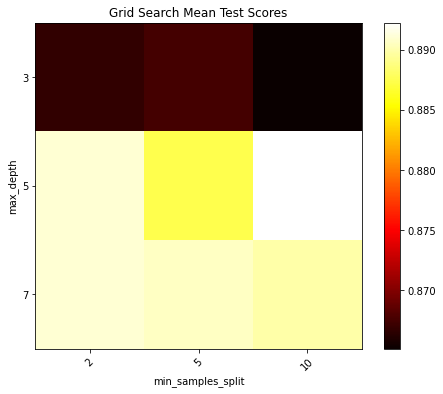

In [28]:
# use this cell to create and print any supporting statistics
scores = np.array(wheeler_randomforestgrid.cv_results_['mean_test_score']).reshape(3, 3)
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(wheeler_parameter_grid['randomforest__min_samples_split'])), wheeler_parameter_grid['randomforest__min_samples_split'], rotation=45)
plt.yticks(np.arange(len(wheeler_parameter_grid['randomforest__max_depth'])), wheeler_parameter_grid['randomforest__max_depth'])
plt.title('Grid Search Mean Test Scores')
plt.show()


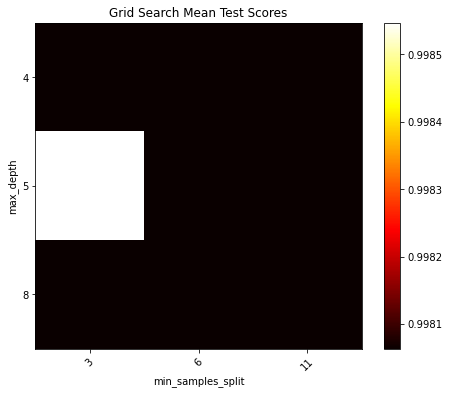

In [31]:
# use this cell to create any supporting graphics
# if you would like to include additional graphics, 
# please add additional cells and create one graphic per cell
scores = np.array(verlander_randomforestgrid.cv_results_['mean_test_score']).reshape(3, 3)

plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(verlander_parameter_grid['randomforest__min_samples_split'])), verlander_parameter_grid['randomforest__min_samples_split'], rotation=45)
plt.yticks(np.arange(len(verlander_parameter_grid['randomforest__max_depth'])), verlander_parameter_grid['randomforest__max_depth'])
plt.title('Grid Search Mean Test Scores')
plt.show()

**Graded discussion:** Would you put the Verlander model in production? Justify you answer. Would you put the Wheeler model in production? Justify you answer.

I think I would put the Verlander model in production. In the prarielearn test, the Verlander model got a Model test accuracy was high: 0.9980657640232108. I would also put the Wheeler model into production because the Model test accuracy was high: 0.9090909090909091. 

**Un-graded discussion:** Do you think these classifiers predict fast enough to work in real-time? How could you improve these classifiers? (Hint: You might need more data.) Why did we model the two pitchers with different models? Why didn't we use the same model for both pitchers?

I think that we would need far more data rather than a selected few that we chose to use these two models on. We needed to create different models for the different pitches because they use different pitches, have different bodies, and clearly pitch differently than how the other pitches. Therefore, were we to use the same model for all pitchers, we would get a model that is very inaccurate rather than building a custom model for each pitcher by taking into account all their pitches. 

## Submission

Before submitting, please review the [**Lab Policy** document](https://cs307.org/lab.html) on the course website. This document contains additional directions for completing and submitting your lab. It also defines the grading rubric for the lab.

**Be sure that you have added your name at the top of this notebook.**

Once you've reviewed the lab policy document, head to [**Canvas**](https://canvas.illinois.edu) to submit your lab notebook.